### Getting the Data

In [ ]:
import json
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


results_root = Path("../outputs/final_results/deepseek-ai_deepseek-coder-1.3b-instruct")
data = []

def extract_energy_from_file(file_path):
    if not file_path.exists():
        return None
    content = file_path.read_text(encoding="utf-8")
    match = re.search(r"Energy consumption in joules:\s*([0-9.]+)", content)
    return float(match.group(1)) if match else None

# Iterate through each condition folder
for condition_folder in results_root.iterdir():
    if not condition_folder.is_dir():
        continue
    
    eval_root = condition_folder / "humaneval_custom"
    
    if eval_root.exists():
        for repeat_folder in eval_root.iterdir():
            summary_file = repeat_folder / "summary.json"
            stdout_file = repeat_folder / "energibridge_stdout.txt"
            
            if summary_file.exists():
                with summary_file.open("r", encoding="utf-8") as f:
                    summary = json.load(f)
                
                energy = extract_energy_from_file(stdout_file)
                metrics = summary.get("metrics", {})
                
                if energy is not None:
                    data.append({
                        "Condition": summary.get("condition"),
                        "Repeat": repeat_folder.name,
                        "Energy (Joules)": energy,
                        "Quality (Levenshtein Ratio)": metrics.get("mean_levenshtein_ratio", 0),
                        "Quality (CodeBLEU)": metrics.get("mean_codebleu", 0)
                    })

df = pd.DataFrame(data)
print(f"Successfully aggregated {len(df)} runs from folders.")

Successfully aggregated 9 runs from folders.


### Trade-off Plot: Energy vs Code Quality

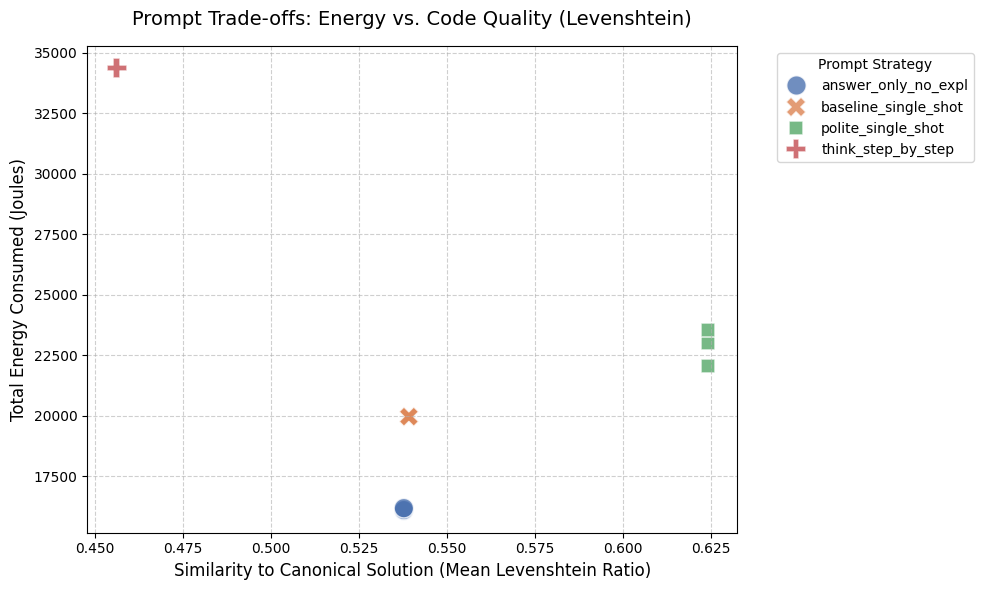

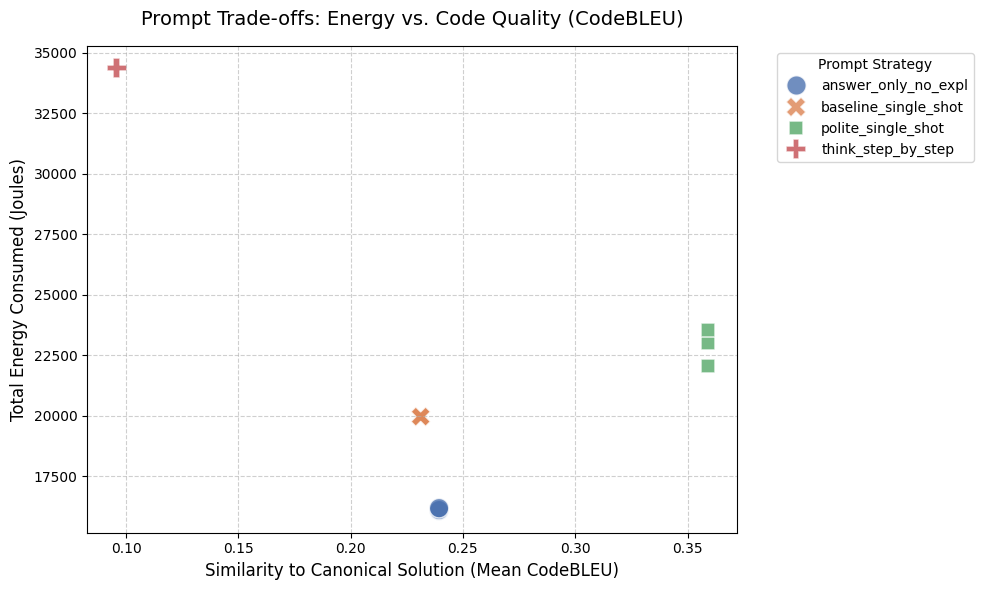

In [7]:
# PLOT 1: RAW SCATTER (LEVENSHTEIN VS ENERGY)
plt.figure(figsize=(10, 6))
ax1 = sns.scatterplot(
    data=df,
    x="Quality (Levenshtein Ratio)", 
    y="Energy (Joules)",
    hue="Condition",
    style="Condition",
    s=200,
    alpha=0.8,
    palette="deep"
)

plt.title("Prompt Trade-offs: Energy vs. Code Quality (Levenshtein)", fontsize=14, pad=15)
plt.xlabel("Similarity to Canonical Solution (Mean Levenshtein Ratio)", fontsize=12)
plt.ylabel("Total Energy Consumed (Joules)", fontsize=12)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Prompt Strategy")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# PLOT 2: RAW SCATTER (CODEBLEU VS ENERGY)
plt.figure(figsize=(10, 6))
ax2 = sns.scatterplot(
    data=df,
    x="Quality (CodeBLEU)", 
    y="Energy (Joules)",
    hue="Condition",
    style="Condition",
    s=200,
    alpha=0.8,
    palette="deep"
)

plt.title("Prompt Trade-offs: Energy vs. Code Quality (CodeBLEU)", fontsize=14, pad=15)
plt.xlabel("Similarity to Canonical Solution (Mean CodeBLEU)", fontsize=12)
plt.ylabel("Total Energy Consumed (Joules)", fontsize=12)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Prompt Strategy")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

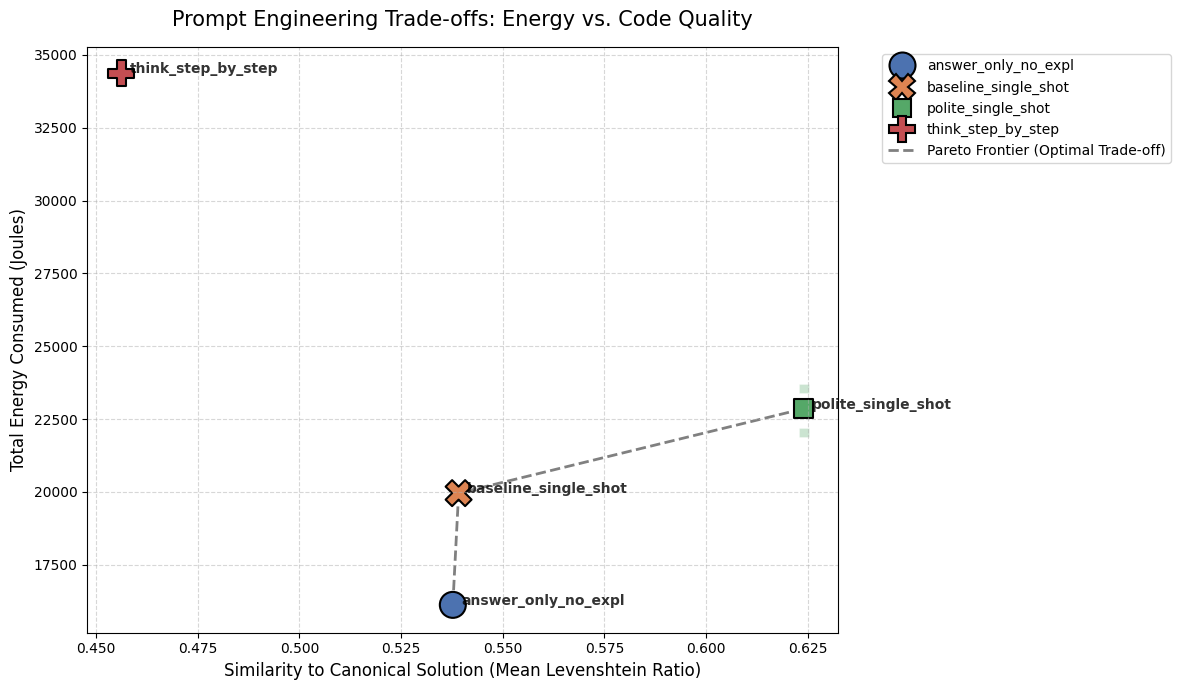

In [ ]:
# Calculate the Centroids (mean energy and mean quality for each condition)
centroids = df.groupby('Condition').agg({
    'Quality (Levenshtein Ratio)': 'mean',
    'Energy (Joules)': 'mean'
}).reset_index()

plt.figure(figsize=(12, 7))

# Plot the raw individual runs
sns.scatterplot(
    data=df,
    x="Quality (Levenshtein Ratio)", 
    y="Energy (Joules)",
    hue="Condition",
    style="Condition",
    s=100,      
    alpha=0.3,  # high transparency
    palette="deep",
    legend=False
)

# Plot the centroids
sns.scatterplot(
    data=centroids,
    x="Quality (Levenshtein Ratio)", 
    y="Energy (Joules)",
    hue="Condition",
    style="Condition",
    s=350,      
    edgecolor='black',
    linewidth=1.5,
    palette="deep"
)

for i, row in centroids.iterrows():
    plt.text(
        row['Quality (Levenshtein Ratio)'] + 0.002, # Small horizontal offset
        row['Energy (Joules)'],                     
        row['Condition'],
        fontsize=10,
        weight='bold',
        alpha=0.8
    )

# Calculate and plot the Pareto Frontier
pareto_sorted = centroids.sort_values('Quality (Levenshtein Ratio)', ascending=False)
frontier = []
min_energy = float('inf')

for _, row in pareto_sorted.iterrows():
    if row['Energy (Joules)'] < min_energy:
        frontier.append(row)
        min_energy = row['Energy (Joules)']

# Sort ascending to draw the line correctly from left to right
frontier_df = pd.DataFrame(frontier).sort_values('Quality (Levenshtein Ratio)')

plt.plot(
    frontier_df['Quality (Levenshtein Ratio)'],
    frontier_df['Energy (Joules)'],
    color='grey',
    linestyle='--',
    linewidth=2,
    zorder=0,
    label='Pareto Frontier (Optimal Trade-off)'
)

plt.title("Prompt Engineering Trade-offs: Energy vs. Code Quality", fontsize=15, pad=15)
plt.xlabel("Similarity to Canonical Solution (Mean Levenshtein Ratio)", fontsize=12)
plt.ylabel("Total Energy Consumed (Joules)", fontsize=12)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

### Trade-off Plot: Energy vs Code Quality (Mean CodeBLEU)

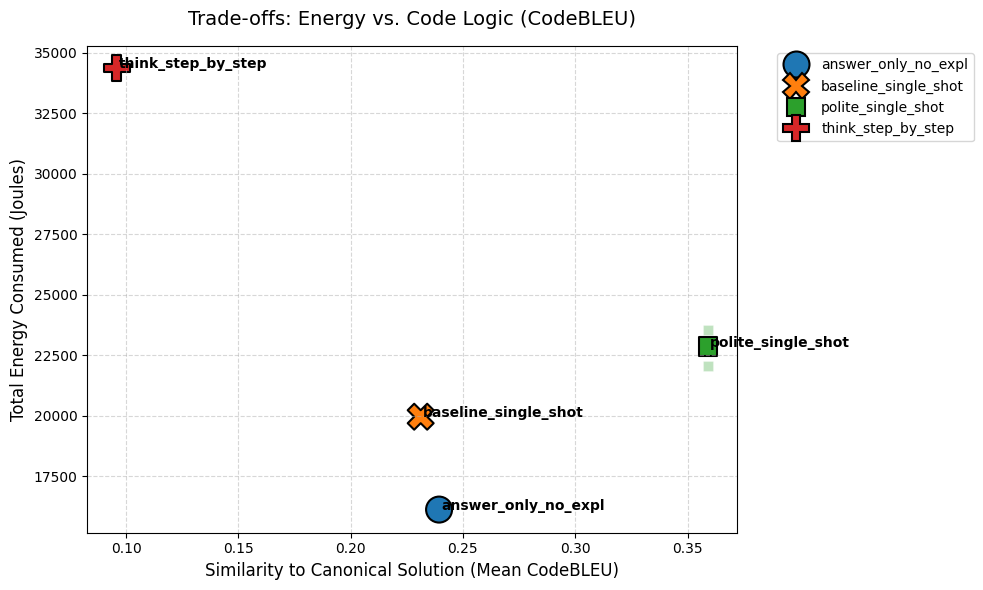

In [ ]:
centroids_cb = df.groupby('Condition').agg({
    'Quality (CodeBLEU)': 'mean',
    'Energy (Joules)': 'mean'
}).reset_index()

plt.figure(figsize=(10, 6))

sns.scatterplot(data=df, x="Quality (CodeBLEU)", y="Energy (Joules)", 
                hue="Condition", style="Condition", s=100, alpha=0.3, legend=False)

sns.scatterplot(data=centroids_cb, x="Quality (CodeBLEU)", y="Energy (Joules)", 
                hue="Condition", style="Condition", s=350, edgecolor='black')

for i, row in centroids_cb.iterrows():
    plt.text(row['Quality (CodeBLEU)'] + 0.001, row['Energy (Joules)'], 
             row['Condition'], fontsize=10, weight='bold')

plt.title("Trade-offs: Energy vs. Code Logic (CodeBLEU)", fontsize=14, pad=15)
plt.xlabel("Similarity to Canonical Solution (Mean CodeBLEU)", fontsize=12)
plt.ylabel("Total Energy Consumed (Joules)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Relative Change Plot (Centered on Baseline)
Centers baseline_single_shot at (0, 0), and divides the plot into quadrants. If a dot lands in the bottom-right quadrant, it is better and cheaper than doing nothing (baseline). If it lands top-left, it is worse and more expensive.

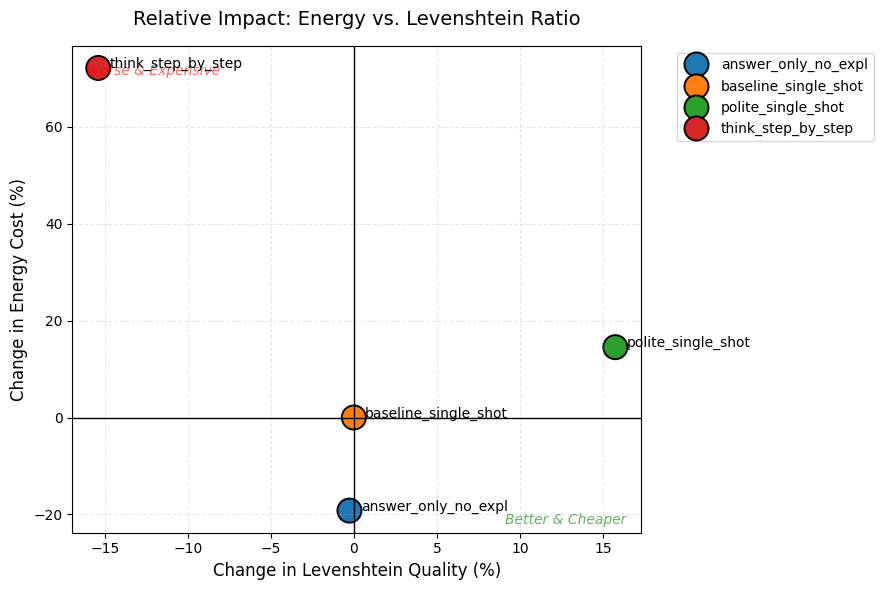

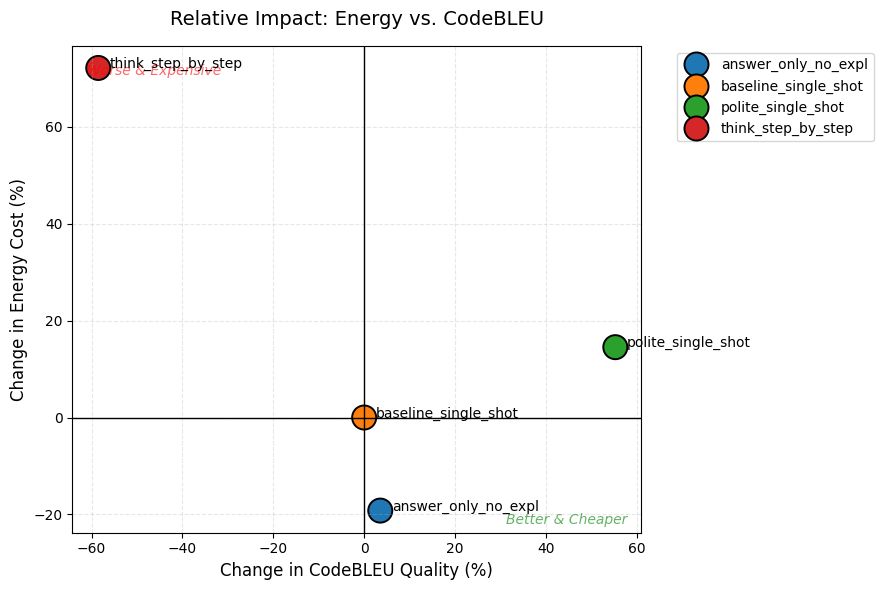

In [ ]:
centroids_all = df.groupby('Condition').agg({
    'Quality (Levenshtein Ratio)': 'mean',
    'Quality (CodeBLEU)': 'mean',
    'Energy (Joules)': 'mean'
}).reset_index()

baseline = centroids_all[centroids_all['Condition'] == 'baseline_single_shot'].iloc[0]
base_lev_val = baseline['Quality (Levenshtein Ratio)']
base_cb_val = baseline['Quality (CodeBLEU)']
base_energy_val = baseline['Energy (Joules)']

deltas = centroids_all.copy()
deltas['Δ Quality (Levenshtein) (%)'] = ((deltas['Quality (Levenshtein Ratio)'] - base_lev_val) / base_lev_val) * 100
deltas['Δ Quality (CodeBLEU) (%)'] = ((deltas['Quality (CodeBLEU)'] - base_cb_val) / base_cb_val) * 100
deltas['Δ Energy (%)'] = ((deltas['Energy (Joules)'] - base_energy_val) / base_energy_val) * 100

# PLOT 1: LEVENSHTEIN VS ENERGY
plt.figure(figsize=(9, 6))

sns.scatterplot(data=deltas, x="Δ Quality (Levenshtein) (%)", y="Δ Energy (%)", 
                hue="Condition", s=300, edgecolor='black')

plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)

x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()

plt.text(x_max * 0.95, y_min * 0.95, 'Better & Cheaper', color='green', alpha=0.6, style='italic', ha='right', va='bottom')
plt.text(x_min * 0.95, y_max * 0.95, 'Worse & Expensive', color='red', alpha=0.6, style='italic', ha='left', va='top')

for i, row in deltas.iterrows():
    x_offset = (x_max - x_min) * 0.02
    plt.text(row['Δ Quality (Levenshtein) (%)'] + x_offset, row['Δ Energy (%)'], 
             row['Condition'], fontsize=10)

plt.title("Relative Impact: Energy vs. Levenshtein Ratio", fontsize=14, pad=15)
plt.xlabel("Change in Levenshtein Quality (%)", fontsize=12)
plt.ylabel("Change in Energy Cost (%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# PLOT 2: CODEBLEU VS ENERGY
plt.figure(figsize=(9, 6))

sns.scatterplot(data=deltas, x="Δ Quality (CodeBLEU) (%)", y="Δ Energy (%)", 
                hue="Condition", s=300, edgecolor='black')

plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)

x_min_cb, x_max_cb = plt.xlim()
y_min_cb, y_max_cb = plt.ylim()

plt.text(x_max_cb * 0.95, y_min_cb * 0.95, 'Better & Cheaper', color='green', alpha=0.6, style='italic', ha='right', va='bottom')
plt.text(x_min_cb * 0.95, y_max_cb * 0.95, 'Worse & Expensive', color='red', alpha=0.6, style='italic', ha='left', va='top')

for i, row in deltas.iterrows():
    x_offset_cb = (x_max_cb - x_min_cb) * 0.02
    plt.text(row['Δ Quality (CodeBLEU) (%)'] + x_offset_cb, row['Δ Energy (%)'], 
             row['Condition'], fontsize=10)

plt.title("Relative Impact: Energy vs. CodeBLEU", fontsize=14, pad=15)
plt.xlabel("Change in CodeBLEU Quality (%)", fontsize=12)
plt.ylabel("Change in Energy Cost (%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Efficiency Ratio Bar Chart

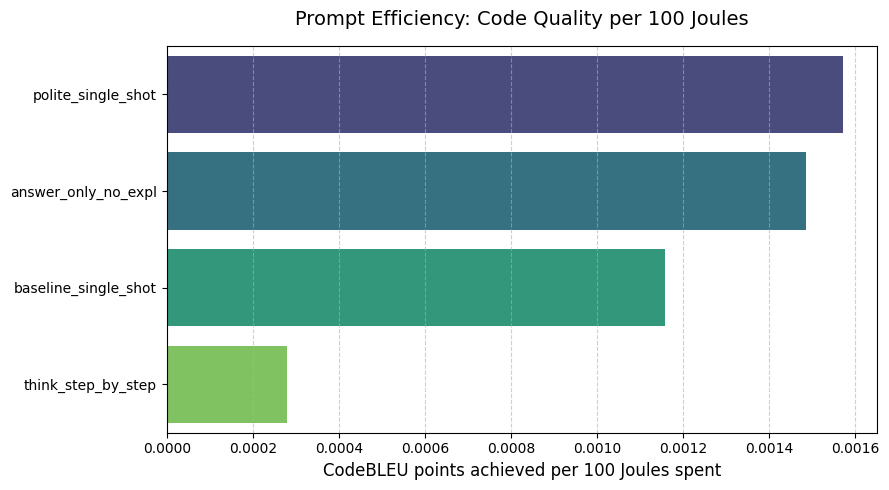

In [ ]:
# PLOT 1: EFFICIENCY RATIO (LEVENSHTEIN)

df_eff_lev = centroids_all.copy()
df_eff_lev['Efficiency Ratio (Levenshtein)'] = (df_eff_lev['Quality (Levenshtein Ratio)'] / df_eff_lev['Energy (Joules)']) * 100

# Sort by most efficient
df_eff_lev = df_eff_lev.sort_values('Efficiency Ratio (Levenshtein)', ascending=False)

plt.figure(figsize=(9, 5))
sns.barplot(data=df_eff_lev, x="Efficiency Ratio (Levenshtein)", y="Condition", palette="viridis", hue="Condition", legend=False)

plt.title("Prompt Efficiency: Levenshtein Ratio per 100 Joules", fontsize=14, pad=15)
plt.xlabel("Levenshtein points achieved per 100 Joules spent", fontsize=12)
plt.ylabel("")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# PLOT 2: EFFICIENCY RATIO (CODEBLEU)

df_eff_cb = centroids_all.copy()
df_eff_cb['Efficiency Ratio (CodeBLEU)'] = (df_eff_cb['Quality (CodeBLEU)'] / df_eff_cb['Energy (Joules)']) * 100

# Sort by most efficient
df_eff_cb = df_eff_cb.sort_values('Efficiency Ratio (CodeBLEU)', ascending=False)

plt.figure(figsize=(9, 5))
sns.barplot(data=df_eff_cb, x="Efficiency Ratio (CodeBLEU)", y="Condition", palette="viridis", hue="Condition", legend=False)

plt.title("Prompt Efficiency: Code Quality (CodeBLEU) per 100 Joules", fontsize=14, pad=15)
plt.xlabel("CodeBLEU points achieved per 100 Joules spent", fontsize=12)
plt.ylabel("")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()